It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.

![](https://cdn.tutsplus.com/net/uploads/legacy/2061_stripe/1.png)

Annual global fraud losses reached $21.8 billion in 2015, according to [Nilson Report](https://www.nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf). 

Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

# Setup

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("data/creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [4]:
df.isnull().values.any()

False

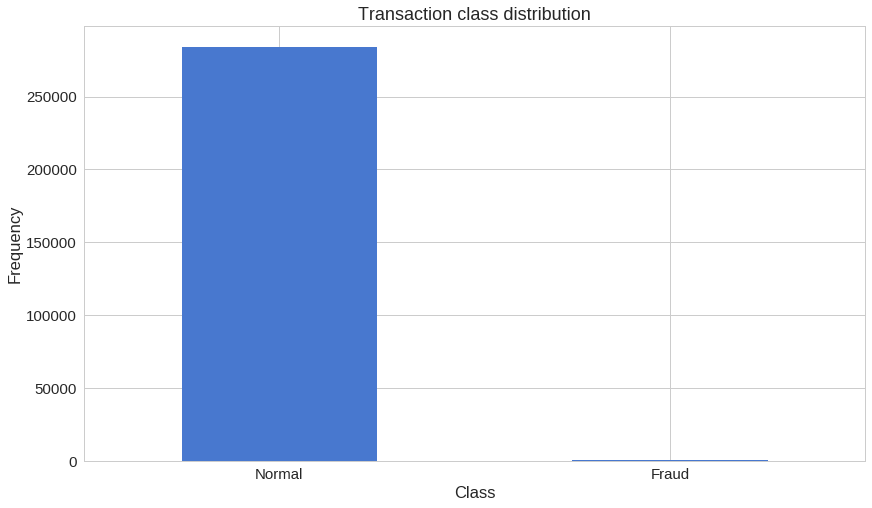

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions: 

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

How different are the amount of money used in different transaction classes?

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation:

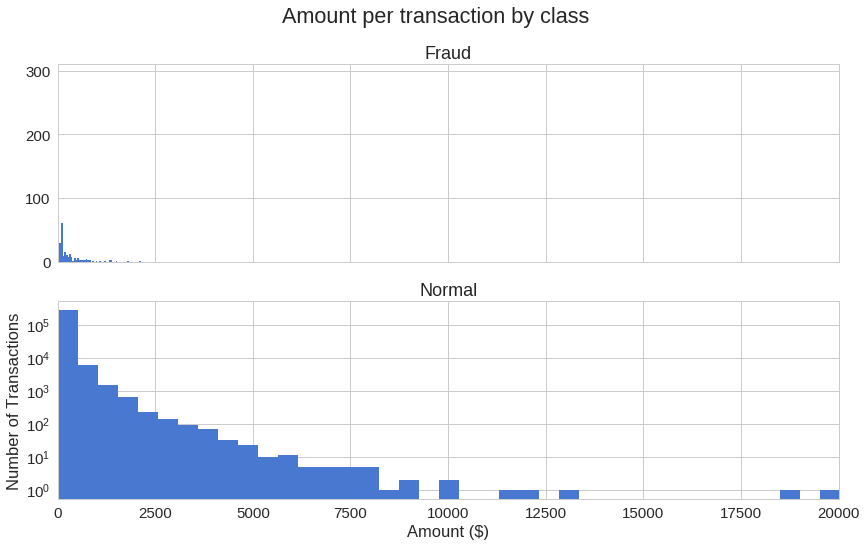

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

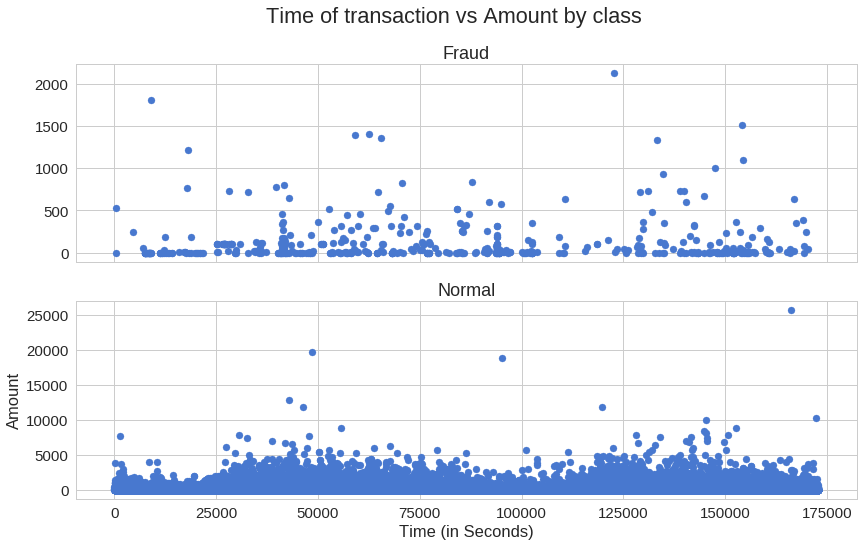

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

<iframe width="100%" height="480" src="https://www.youtube.com/embed/FzS3tMl4Nsc" frameborder="0" allowfullscreen></iframe>

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [13]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of nonfraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [14]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [15]:
X_train.shape

(227451, 29)

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [16]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [17]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [18]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 23s - loss: 0.8092 - acc: 0.5854 - val_loss: 0.7881 - val_acc: 0.6481
Epoch 2/100
227451/227451 [==============================] - 22s - loss: 0.7506 - acc: 0.6517 - val_loss: 0.7768 - val_acc: 0.6525
Epoch 3/100
227451/227451 [==============================] - 22s - loss: 0.7427 - acc: 0.6558 - val_loss: 0.7731 - val_acc: 0.6500
Epoch 4/100
227451/227451 [==============================] - 22s - loss: 0.7393 - acc: 0.6569 - val_loss: 0.7710 - val_acc: 0.6604
Epoch 5/100
227451/227451 [==============================] - 22s - loss: 0.7369 - acc: 0.6581 - val_loss: 0.7686 - val_acc: 0.6553
Epoch 6/100
227451/227451 [==============================] - 22s - loss: 0.7351 - acc: 0.6595 - val_loss: 0.7672 - val_acc: 0.6661
Epoch 7/100
227451/227451 [==============================] - 23s - loss: 0.7338 - acc: 0.6629 - val_loss: 0.7662 - val_acc: 0.6636
Epoch 8/100
227451/227451 [=====

227451/227451 [==============================] - 22s - loss: 0.7180 - acc: 0.6957 - val_loss: 0.7525 - val_acc: 0.6998
Epoch 63/100
227451/227451 [==============================] - 23s - loss: 0.7185 - acc: 0.6963 - val_loss: 0.7511 - val_acc: 0.7008
Epoch 64/100
227451/227451 [==============================] - 27s - loss: 0.7175 - acc: 0.6971 - val_loss: 0.7511 - val_acc: 0.7015
Epoch 65/100
227451/227451 [==============================] - 25s - loss: 0.7175 - acc: 0.6964 - val_loss: 0.7499 - val_acc: 0.7032
Epoch 66/100
227451/227451 [==============================] - 24s - loss: 0.7179 - acc: 0.6967 - val_loss: 0.7544 - val_acc: 0.6888
Epoch 67/100
227451/227451 [==============================] - 28s - loss: 0.7179 - acc: 0.6967 - val_loss: 0.7502 - val_acc: 0.7017
Epoch 68/100
227451/227451 [==============================] - 27s - loss: 0.7176 - acc: 0.6953 - val_loss: 0.7541 - val_acc: 0.6941
Epoch 69/100
227451/227451 [==============================] - 29s - loss: 0.7186 - acc: 0

In [19]:
autoencoder = load_model('model.h5')

# Evaluation

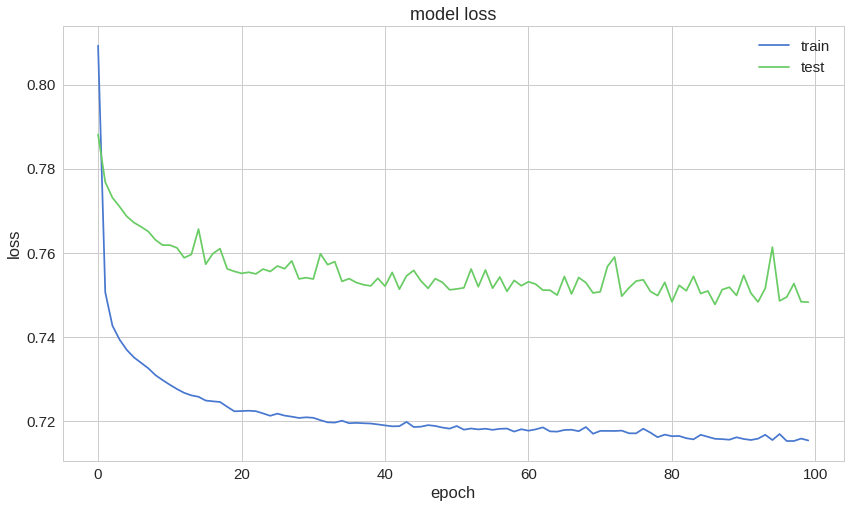

In [39]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Let's have a closer look at the error distribution:

In [21]:
predictions = autoencoder.predict(X_test)

In [23]:
def get_df(test_data, predictions, truth_labels):
    mse = np.mean(np.power(test_data - predictions, 2), axis=1)
    return pd.DataFrame({'reconstruction_error': mse, 'true_class': truth_labels})

In [24]:
res_df = get_df(X_test, predictions, y_test)

In [25]:
res_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735750,0.001720
std,3.403551,0.041443
min,0.033858,0.000000
25%,0.233895,0.000000
50%,0.383530,0.000000
75%,0.621950,0.000000
max,263.539548,1.000000


## Reconstruction error w/o fraud

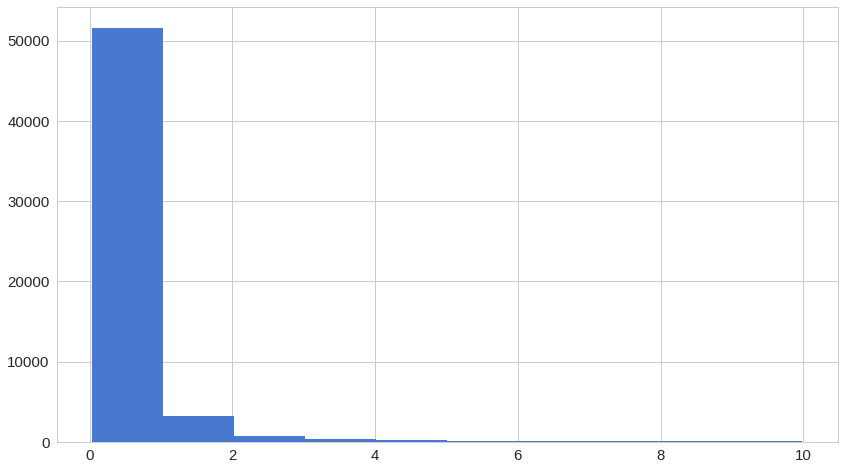

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(res_df[(res_df['true_class']== 0) & (res_df['reconstruction_error'] < 10)].reconstruction_error.values, bins=10)

## Reconstruction error with fraud

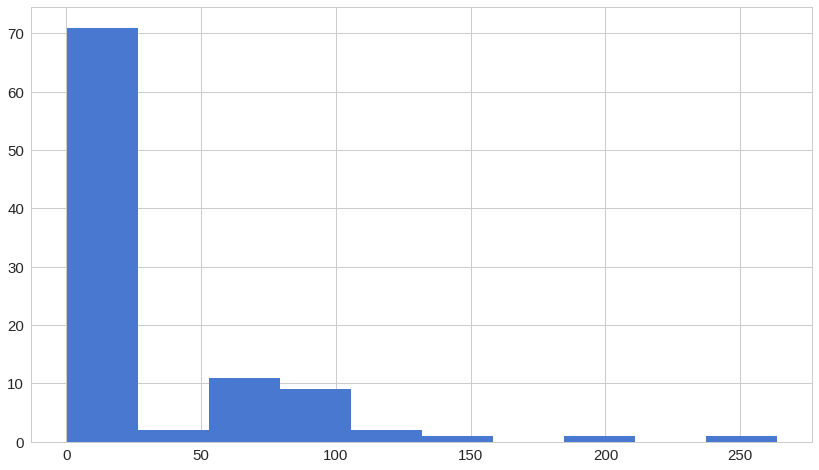

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(res_df[res_df['true_class'] > 0].reconstruction_error.values, bins=10)

In [28]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

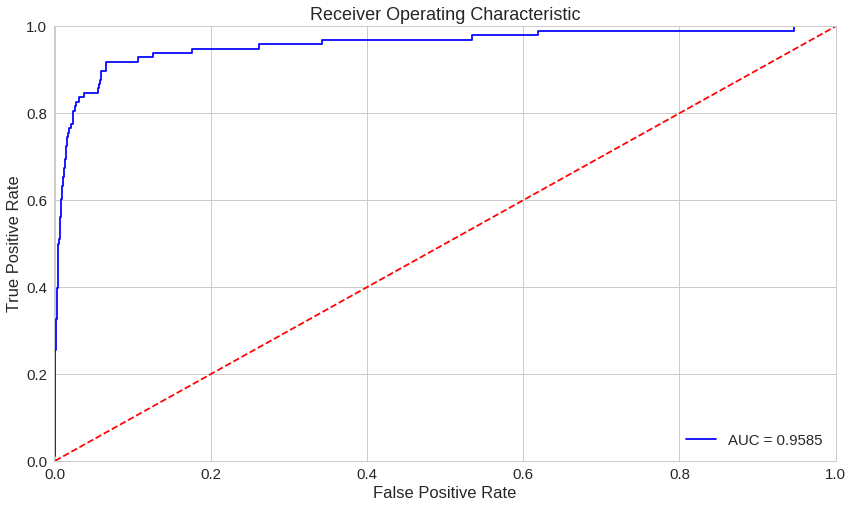

In [29]:
fpr, tpr, thresholds = roc_curve(res_df.true_class, res_df.reconstruction_error)
roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

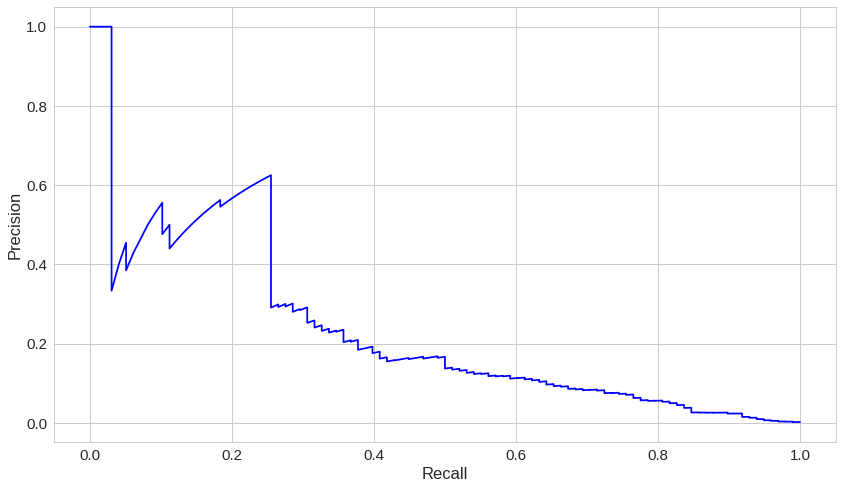

In [30]:
precision, recall, th = precision_recall_curve(res_df.true_class, res_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

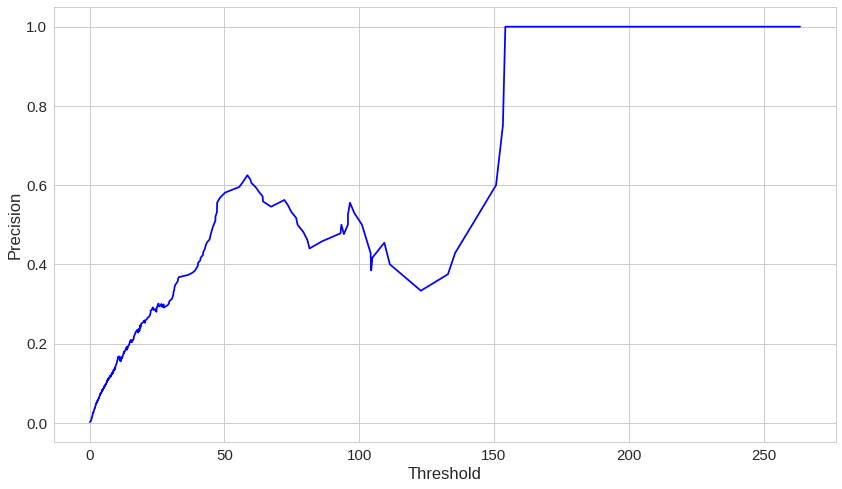

In [31]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

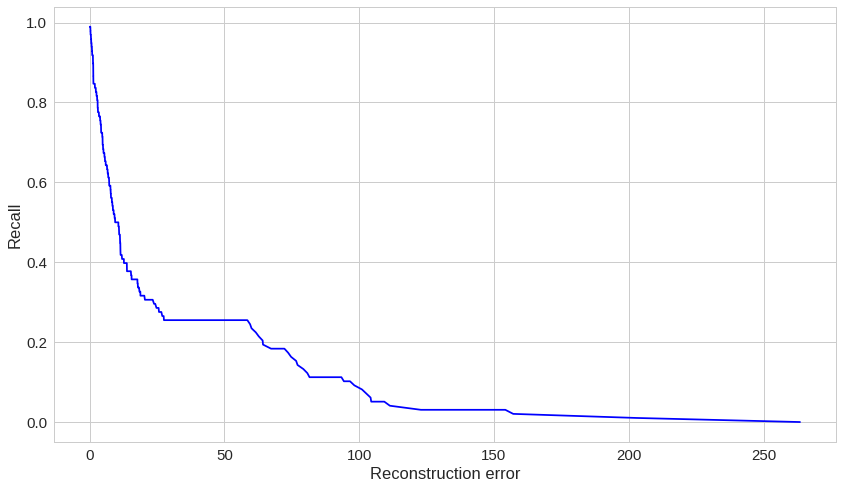

In [32]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [33]:
threshold = 3.0

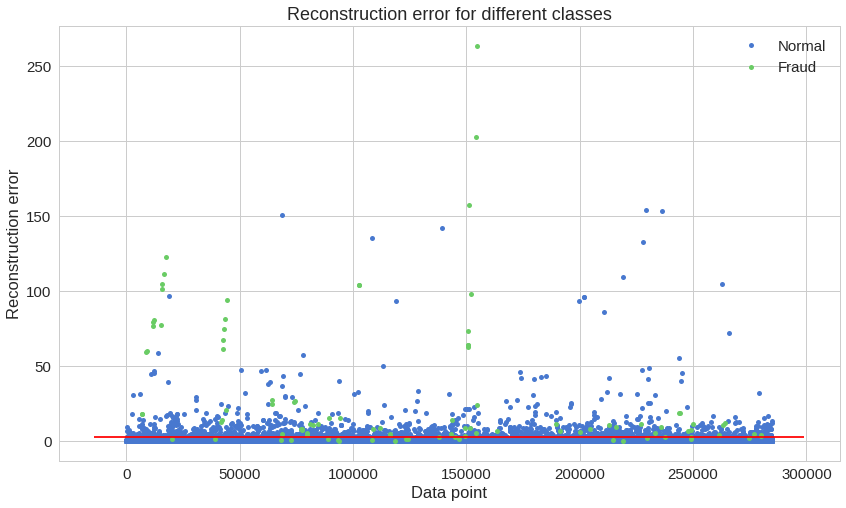

In [34]:
groups = res_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.legend()
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point")
plt.show();

# Prediction

In [35]:
y_pred = [1 if e > threshold else 0 for e in res_df.reconstruction_error.values]
conf_matrix = confusion_matrix(res_df.true_class, y_pred)

print("Recall metric in the testing dataset: ", float(conf_matrix[1,1])/(conf_matrix[1,0]+conf_matrix[1,1]))

Recall metric in the testing dataset:  0.795918367347


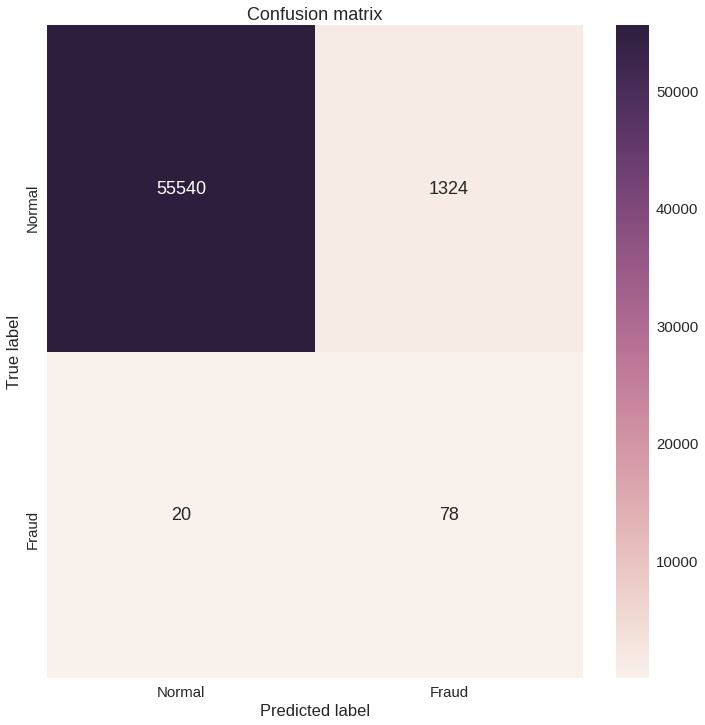

In [36]:
width = 12
height = 12
plt.figure(figsize=(width, height))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# References

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)